## MADlib Greenplum Demo
---

### Import neccessary Data Science libraries

In [1]:
%matplotlib widget
import warnings
warnings.filterwarnings("ignore")

import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', 200)

Connect to Greenplum Database

In [2]:
%load_ext sql

In [3]:
!minikube service list

|-------------|------------------------------------------------------|--------------|------------------------------|
|  NAMESPACE  |                         NAME                         | TARGET PORT  |             URL              |
|-------------|------------------------------------------------------|--------------|------------------------------|
| default     | agent                                                | No node port |
| default     | greenplum                                            | psql/5432    | http://192.168.133.128:32000 |
| default     | greenplum-validating-webhook-service-9d44d9fcf-t26tq | No node port |
| default     | kubernetes                                           | No node port |
| default     | my-greenplum-pl                                      | No node port |
| default     | my-greenplum-pxf                                     | No node port |
| kube-system | kube-dns                                             | No node port |
|-------------|-

In [4]:
%sql postgresql://gpadmin@192.168.133.128:32000/db

        
%sql SELECT version();

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


version
"PostgreSQL 9.4.24 (Greenplum Database 6.11.2 build commit:d611e78af2c5a6561ccbbaf2b4652138410f9aeb) on x86_64-unknown-linux-gnu, compiled by gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0, 64-bit compiled on Sep 30 2020 05:25:08"


### Check Database Data

In [5]:
%%sql


SELECT COUNT(*) AS num_sample FROM sensors;

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


num_sample
200000


In [6]:
%%sql

SELECT * FROM sensors LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
10 rows affected.


timestamp,temperature,temperature_2,humidity,pm25
1997-03-22 00:00:00,30.6668585650253,42.9052858044298,69.2785492479998,73.1767528823951
1997-03-22 04:00:00,32.2240553161353,48.4451885030855,61.2088571248697,103.956207334568
1997-03-22 12:00:00,32.4185793403592,46.2930967363855,69.3046298170464,87.3012012853493
1997-03-22 20:00:00,31.6889779538602,50.3771697898689,53.2251690054103,76.757504341768
1997-03-22 21:00:00,31.414135143836,45.8292816079858,53.655786244688,77.837155684718
1997-03-22 22:00:00,31.5117735558417,49.7762550293786,31.5185341489772,98.0131261241892
1997-03-23 04:00:00,30.9732062825728,50.7305651158765,51.6463117699311,76.6613962119159
1997-03-23 06:00:00,31.1456715016839,50.5883567654865,50.6392021695488,77.1011145867884
1997-03-23 08:00:00,32.9173479628012,48.2255788669841,62.5489084902205,87.1120555127665
1997-03-23 12:00:00,32.5277304291036,47.7246721062276,15.1710744913787,91.5709933365243


In [7]:
sensors = %sql SELECT * FROM sensors LIMIT 1000;
sensors = sensors.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
1000 rows affected.


In [8]:
sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      1000 non-null   datetime64[ns]
 1   temperature    1000 non-null   float64       
 2   temperature_2  1000 non-null   float64       
 3   humidity       1000 non-null   float64       
 4   pm25           1000 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 39.2 KB


In [9]:
sensors.describe()

,temperature,temperature_2,humidity,pm25
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,31.546704,46.562115,49.825844,89.552287
std,0.872289,3.139024,14.967374,14.430473
min,30.002098,34.493309,1.160944,38.564782
25%,30.819098,44.387437,39.490404,79.670134
50%,31.576531,46.438833,50.040946,89.644032
75%,32.325675,48.665443,60.295111,99.163126
max,33.004882,55.152494,93.333323,132.791284


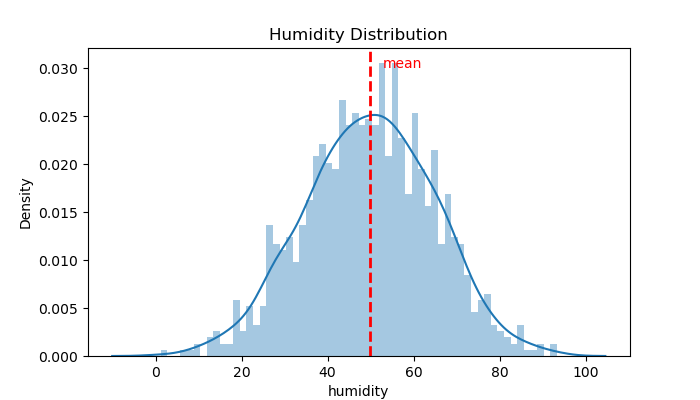

In [10]:
plt.figure(figsize=(7,4))
sns.distplot(sensors['humidity'],bins=60);
plt.title("Humidity Distribution")
plt.axvline(x=sensors['humidity'].mean(),color='red',ls='--',lw=2)
plt.text(sensors['humidity'].mean()+3,0.03, "mean", fontsize=10,c='red');

### EDA

In [11]:
%%sql
DROP TABLE IF EXISTS sensors_summary ;
SELECT madlib.summary (
    'sensors',  -- source_table
    'sensors_summary',  -- output_table
    NULL,  -- target_cols
    NULL,  -- grouping_cols
    TRUE,  -- get_distinct
    TRUE,  -- get_quartiles
    NULL,  -- quantile_array
    10,    -- how_many_mfv
    FALSE  -- get_estimate
);

SELECT * FROM sensors_summary LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
None,None,"""timestamp""",1,timestamp,200000,200000,0,None,0.0,None,None,None,None,None,None,None,None,None,None,None,None,"['2019-07-25 11:00:00', '2019-12-01 19:00:00', '2019-11-03 16:00:00', '2019-11-23 21:00:00', '2019-11-26 21:00:00', '2019-12-21 14:00:00', '2020-01-03 09:00:00', '2019-11-30 16:00:00', '2019-12-15 03:00:00', '2019-11-05 15:00:00']","[202, 201, 197, 196, 196, 196, 196, 195, 194, 193]"
None,None,temperature,2,float8,200000,200000,0,None,0.0,None,200000,0,0,32.0007889310936,0.833918535707913,"[31.9967866933153, 32.0047911688719]",30.0020976922364,33.9932399275613,31.2506718159847,32.0007082471155,32.7509473341128,"['31.3932971558727', '31.1270586631445', '31.5795452103724', '31.3809975772738', '33.8450611683449', '31.0611840491863', '32.9212582895504', '33.8943804292179', '32.1098964308206', '31.1571707561875']","[204, 197, 196, 196, 195, 195, 195, 195, 195, 195]"
None,None,temperature_2,3,float8,200000,200000,0,None,0.0,None,200000,0,0,46.99570081252,9.80804681580791,"[46.9819751809047, 47.0094264441353]",32.2943907804811,61.6835823795163,44.8807517740374,46.9961843733011,49.112212070946,"['45.610033372541', '41.8933542334198', '48.7487345239526', '42.8628249997972', '51.7284036547247', '53.0636555990058', '49.144793481834', '42.5560303222563', '49.2545157623079', '53.5363445515196']","[200, 198, 198, 198, 198, 196, 196, 196, 196, 196]"
None,None,humidity,4,float8,200000,200000,0,None,0.0,None,199916,84,0,50.0315077284909,224.568211224632,"[49.9658304401699, 50.0971850168119]",-20.3266268501857,118.488627743178,39.9160404829,50.0412446801503,60.1484803615784,"['80.0789399962446', '58.9158137497979', '49.5808709283595', '40.8370079457451', '44.2457888796278', '81.0299847843547', '61.0819306716374', '71.5458767971577', '68.9138189296112', '57.5480243504294']","[200, 198, 198, 198, 197, 196, 194, 193, 193, 193]"
None,None,pm25,5,float8,200000,200000,0,None,0.0,None,200000,0,0,94.9567258520912,232.817325310956,"[94.8898531731814, 95.023598531001]",24.4732311088685,161.947176404423,84.6258824447947,94.9361338249605,105.200500570932,"['81.0193782019894', '113.419361265646', '111.01717457287', '86.2007469815971', '114.26224363525', '106.088352504439', '75.1810545024631', '115.516321815534', '68.4794225328913', '86.1884482285641']","[199, 198, 198, 198, 197, 196, 195, 195, 194, 194]"


In [12]:
%%sql

DROP TABLE IF EXISTS temp_sensors_timeseries;

CREATE TABLE temp_sensors_timeseries(
    year INTEGER,
    month INTEGER,
    average_month_temperature FLOAT,
    average_pm25 FLOAT
);

INSERT INTO temp_sensors_timeseries 
    SELECT  date_part('year', timestamp) AS year,
            date_part('month', timestamp) AS month,
            avg(temperature) AS average_month_temperature, 
            avg(pm25) AS average_pm25
    FROM sensors
    GROUP BY year, month;
    
    
SELECT * FROM temp_sensors_timeseries ORDER BY year,month LIMIT 20;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
275 rows affected.
20 rows affected.


year,month,average_month_temperature,average_pm25
1997,3,31.5857867033122,89.6407995010372
1997,4,31.5333406560482,89.6954069445576
1997,5,31.5315084500734,88.9290781034526
1997,6,31.5087124676383,89.8276532672497
1997,7,31.4963020069132,89.946082918828
1997,8,31.5052959282945,89.8274028619428
1997,9,31.515806039429,89.6975457387193
1997,10,31.5212258387757,90.5202452816575
1997,11,31.5863566049458,90.7640554348525
1997,12,31.5260226914037,89.2248603940916


In [13]:
timeseries= %sql SELECT * FROM temp_sensors_timeseries ORDER BY year,month;
timeseries=timeseries.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
275 rows affected.


In [14]:
timeseries['date']=pd.DatetimeIndex(timeseries['year'].map("{:04}".format)+'-'+ timeseries['month'].map("{:02}".format))
timeseries.head()

,year,month,average_month_temperature,average_pm25,date
0,1997,3,31.585787,89.640800,1997-03-01
1,1997,4,31.533341,89.695407,1997-04-01
2,1997,5,31.531508,88.929078,1997-05-01
3,1997,6,31.508712,89.827653,1997-06-01
4,1997,7,31.496302,89.946083,1997-07-01


IntSlider(value=10, continuous_update=False, description='timeframe', max=200, min=10)

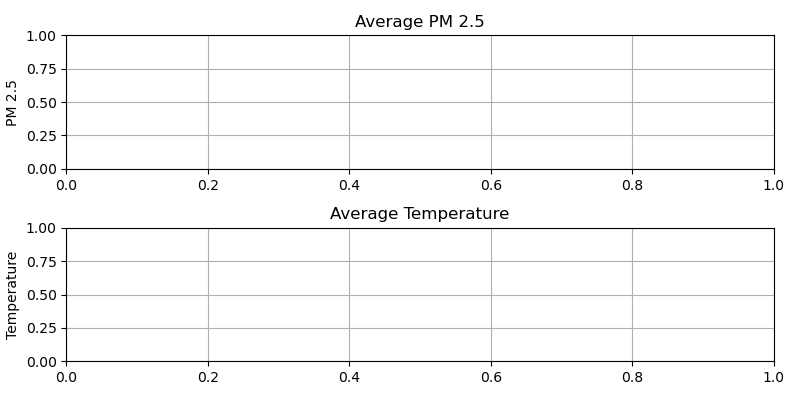

In [15]:
%matplotlib widget
f, (ax1,ax2) = plt.subplots(2,1,figsize=(8,4))

ax1.grid()
ax2.grid()

def update(change):
    ax1.plot(timeseries['date'][:change.new],timeseries['average_pm25'][:change.new],color='blue')
    ax2.plot(timeseries['date'][:change.new],timeseries['average_month_temperature'][:change.new],color='orange')
    f.canvas.draw()

slider = widgets.IntSlider(value=1,min=10,max=200,step=1,continuous_update=False,description='timeframe')

ax1.yaxis.set_label_text("PM 2.5")
ax1.title.set_text('Average PM 2.5')

ax2.title.set_text('Average Temperature')
ax2.yaxis.set_label_text('Temperature')
plt.tight_layout()

slider.observe(update,'value')
slider

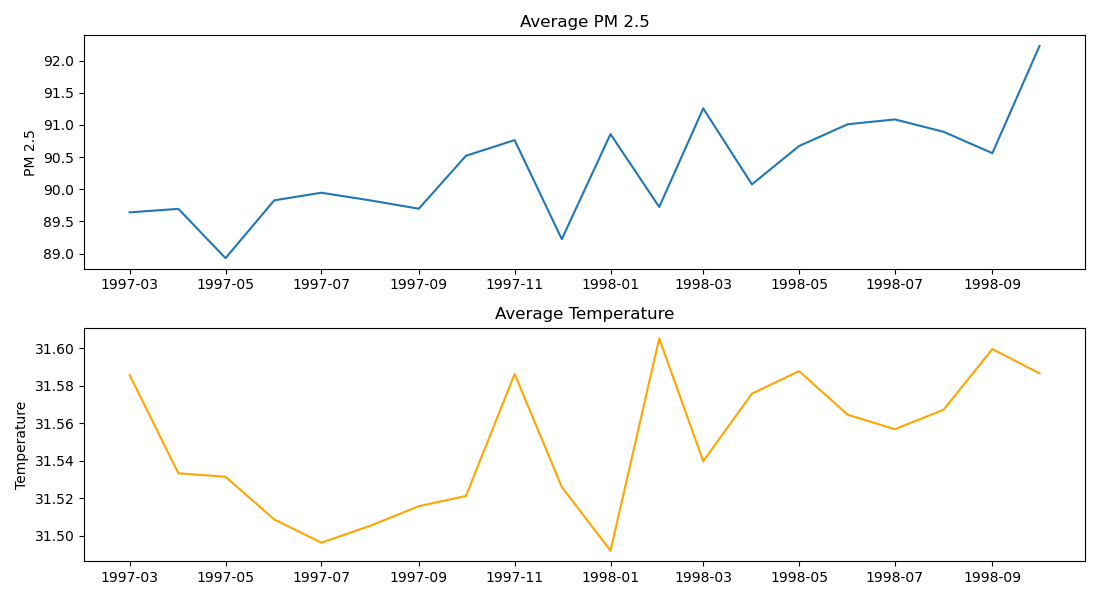

In [16]:
timeframe = 20

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(11,6))
ax1.plot(timeseries['date'][:timeframe],timeseries['average_pm25'][:timeframe])
ax2.plot(timeseries['date'][:timeframe],timeseries['average_month_temperature'][:timeframe],color='orange')

ax1.yaxis.set_label_text("PM 2.5")
ax1.title.set_text('Average PM 2.5')

ax2.title.set_text('Average Temperature')
ax2.yaxis.set_label_text('Temperature')
plt.tight_layout()

### Preprocess Data

Encode Month

```sql
CREATE FUNCTION parse_month(time_stamp timestamp)
  RETURNS char
AS $$
  from datetime import datetime
  date_obj=datetime.strptime(time_stamp,"%Y-%m-%d %H:%M:%S")
  return date_obj.strftime("%B")
$$ LANGUAGE plpythonu;
```

In [17]:
%%sql
SELECT *,parse_month(timestamp) FROM sensors WHERE pm25 > 160;

 * postgresql://gpadmin@192.168.133.128:32000/db
2 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,parse_month
2014-11-23 21:00:00,30.8058720843154,42.7842327160495,44.8122950799332,161.947176404423,November
2015-04-16 22:00:00,33.0799518195087,50.5450234515165,40.0489227220552,161.772615888742,April


Create Month and rain Data

In [18]:
%%sql
DROP TABLE IF EXISTS sensors_pre;
CREATE TABLE sensors_pre
AS 
SELECT
    timestamp,
    temperature,
    temperature_2,
    humidity,
    pm25,
    parse_month(timestamp) AS month,           --- Month data
    CASE WHEN
            (humidity )>= 60
        THEN 1
        ELSE 0
    END as rain
FROM sensors;

SELECT * FROM sensors_pre LIMIT 10; 

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
200000 rows affected.
10 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,month,rain
1997-03-22 02:00:00,30.4533424689492,51.2516337638043,54.3077105793251,81.7230080720579,March,0
1997-03-22 06:00:00,31.0589159812612,48.4483672090038,69.1224817874239,84.0017698370338,March,1
1997-03-22 09:00:00,30.610843351938,47.9068538130067,49.1196591878833,86.6867943800261,March,0
1997-03-22 16:00:00,31.7723650198281,51.4440185456342,31.7819252443621,87.6262312888401,March,0
1997-03-22 18:00:00,32.1746436430727,38.9322676378785,47.5760370578506,98.8517111680278,March,0
1997-03-23 15:00:00,31.1740583596868,48.1492161466837,27.7011496088919,85.1860621068209,March,0
1997-03-24 06:00:00,31.8857807222548,40.9424335381066,43.0283526868108,94.5809235952502,March,0
1997-03-24 18:00:00,30.0944274235999,45.3679702823693,7.12721825870101,93.5019659943016,March,0
1997-03-25 07:00:00,31.7067156114622,49.4560849057285,22.1327113887204,76.6808380403661,March,0
1997-03-25 11:00:00,30.3790320922482,43.4645502623148,40.1004912837385,87.7374230771197,March,0


In [19]:
%%sql
SELECT parse_month(timestamp) as month ,COUNT(*) as count  
    FROM sensors  
GROUP BY month ORDER BY count DESC;

 * postgresql://gpadmin@192.168.133.128:32000/db
12 rows affected.


month,count
December,17112
May,17112
August,17112
July,17112
October,17112
January,16688
March,16608
November,16560
June,16560
April,16560


### Encode categorical values

In [20]:
%%sql
DROP TABLE IF EXISTS sensors_encoded;


SELECT
madlib.encode_categorical_variables (
    'sensors_pre',
    'sensors_encoded',
    'month',
    NULL,  --categorical_cols_to_exclude     -- Optional
    NULL,  --row_id,                         -- Optional
    NULL,  --top,                            -- Optional
    NULL,  --value_to_drop,                  -- Optional
    NULL,  --encode_null,                    -- Optional
    NULL,  --output_type,                    -- Optional
    NULL,  --output_dictionary,              -- Optional
    NULL   --distributed_by                  -- Optional
);


SELECT * FROM sensors_encoded LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,rain,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
1997-03-22 18:00:00,32.1746436430727,38.9322676378785,47.5760370578506,98.8517111680278,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-23 15:00:00,31.1740583596868,48.1492161466837,27.7011496088919,85.1860621068209,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-24 06:00:00,31.8857807222548,40.9424335381066,43.0283526868108,94.5809235952502,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-24 18:00:00,30.0944274235999,45.3679702823693,7.12721825870101,93.5019659943016,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-25 07:00:00,31.7067156114622,49.4560849057285,22.1327113887204,76.6808380403661,0,0,0,0,0,0,0,0,1,0,0,0,0


### Correlation

In [21]:
%%sql
DROP TABLE IF EXISTS sensors_correlations;
DROP TABLE IF EXISTS sensors_correlations_summary;

SELECT 
madlib.correlation(
    'sensors_encoded', -- source_table
    'sensors_correlations',  -- target_table
    'temperature,temperature_2,humidity,pm25,rain',
    TRUE -- verbose
)

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.


correlation
"Summary for 'Correlation' functionOutput table = sensors_correlationsProducing correlation for columns: temperature,temperature_2,humidity,pm25,rainTotal run time = ('sensors_correlations', 5, 4.308641195297241)"


In [22]:
Index = %sql SELECT variable FROM sensors_correlations ORDER BY column_position;
Index = Index.DataFrame();

columns =  ','.join(','.join('%s' %x for x in y) for y in Index.values)
print(columns)

 * postgresql://gpadmin@192.168.133.128:32000/db
5 rows affected.
temperature,temperature_2,humidity,pm25,rain


In [23]:
corr = %sql select variable,{columns} from sensors_correlations ORDER BY column_position;
corr = corr.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
5 rows affected.


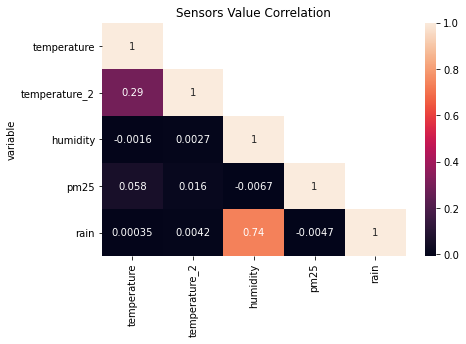

In [24]:
%matplotlib inline
corr_df=corr.set_index('variable')
plt.title('Sensors Value Correlation')
plt.tight_layout()
sns.heatmap(corr_df,annot=True);

### Split Data for training and testing

In [25]:
%%sql
DROP TABLE IF EXISTS sensors_split CASCADE;
DROP TABLE IF EXISTS sensors_split_train CASCADE;
DROP TABLE IF EXISTS sensors_split_test CASCADE;

SELECT madlib.train_test_split(
    'sensors_encoded', -- source_table,
    'sensors_split', -- output_table,
    0.7, -- train_proportion,
    NULL, -- test_proportion,
    NULL, -- grouping_cols,
    'temperature,temperature_2,rain,humidity,pm25,
    "month_January","month_February","month_March",
    "month_April","month_May","month_June","month_July",
    "month_August","month_September","month_October",
    "month_November","month_December"', -- target_cols
    FALSE, -- with_replacement,
    TRUE -- separate_output_tables
);

SELECT COUNT(*) as "# In training set" FROM sensors_split_train;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
Done.
1 rows affected.
1 rows affected.


# In training set
140000


In [26]:
%%sql
SELECT * FROM sensors_split_train LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
5 rows affected.


temperature,temperature_2,rain,humidity,pm25,month_January,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,month_November,month_December
30.0020976922364,46.2490759066801,0,49.2857299756857,66.884884616028,0,0,0,1,0,0,0,0,0,0,0,0
30.0121881215459,43.9185448838402,1,61.3855425905919,110.631678818726,0,0,0,0,0,1,0,0,0,0,0,0
30.0232051453701,43.9816597839706,0,40.0229029416251,79.4034362899984,0,0,0,0,0,0,0,0,1,0,0,0
30.0333834802469,45.1599830306848,0,55.236497558661,69.5186903575826,0,0,1,0,0,0,0,0,0,0,0,0
30.0444010748808,46.7088725241075,0,55.8598711803509,121.988238189472,0,0,0,1,0,0,0,0,0,0,0,0


In [27]:
train_rain = %sql SELECT COUNT(*) FROM sensors_split_train WHERE rain = 1;
test_rain = %sql SELECT COUNT(*) FROM sensors_split_test WHERE rain = 1;

print("\nTotal rain in training set {}".format(train_rain[0][0]))
print("Total rain in testing set {}".format(test_rain[0][0]))

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.
 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.

Total rain in training set 35516
Total rain in testing set 15099


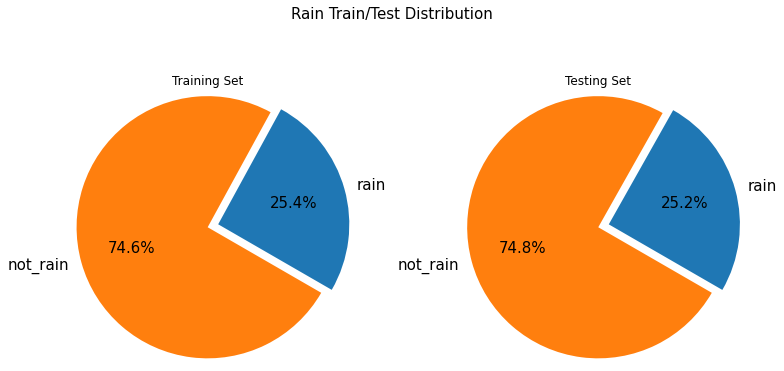

In [28]:
train_data=[train_rain[0][0],int((200000*0.7)-train_rain[0][0])]
test_data=[test_rain[0][0],int((200000*0.3)-test_rain[0][0])]

labels = ['rain','not_rain']

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(11,6))
f.patch.set_facecolor('white')
ax1.title.set_text('Training Set')
ax2.title.set_text('Testing Set')
f.suptitle("Rain Train/Test Distribution",fontsize=15)
ax1.pie(train_data,labels=labels,autopct="%.1f%%",radius=1.2,textprops={'fontsize': 15,},explode = [0.1, 0],startangle = -30);
ax2.pie(test_data,labels=labels,autopct="%.1f%%",radius=1.2,textprops={'fontsize': 15},explode = [0.1, 0], startangle = -30);
plt.tight_layout()

## Logistic Regresion ( Classification model )

In [5]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_model;
DROP TABLE IF EXISTS sensors_logreg_model_summary;

SELECT
    madlib.logregr_train(        -- Train the Logistic Regression Model
        'sensors_split_train',   -- source_table,
        'sensors_logreg_model',  -- out_table,
        'rain',                  -- labels,
        'ARRAY[
            1,
            temperature,
            temperature_2,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"]'       -- feature
        --, -- grouping_cols,
        --, -- max_iter,
        --, -- optimizer,
        --, -- tolerance,
        -- verbose
    )
;
SELECT * FROM sensors_logreg_model_summary ;           --- Get the summary table

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.
1 rows affected.


method,source_table,out_table,dependent_varname,independent_varname,optimizer_params,num_all_groups,num_failed_groups,num_rows_processed,num_missing_rows_skipped,grouping_col
logregr,sensors_split_train,sensors_logreg_model,rain,"ARRAY[ 1, temperature, temperature_2, humidity,pm25, ""month_January"",""month_February"",""month_March"", ""month_April"",""month_May"",""month_June"", ""month_July"",""month_August"",""month_September"", ""month_October"",""month_November"",""month_December""]","optimizer=irls, max_iter=20, tolerance=0.0001",1,0,140000,0,None


In [6]:
logreg_coefs = %sql SELECT coef FROM sensors_logreg_model ;
logreg_coefs = logreg_coefs.DataFrame();

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


In [7]:
logreg_coef_names = (
    'intercept',
    'temperature',
    'temperature_2',
    'humidity',
    'pm25',
    "month_January","month_February","month_March",
    "month_April","month_May","month_June","month_July",
    "month_August","month_September","month_October",
    "month_November","month_December"
)
tuple(zip(logreg_coef_names, logreg_coefs.iloc[0, 0]))

(('intercept', -15399.0232824452),
 ('temperature', -0.140348591652333),
 ('temperature_2', 0.0923544416781965),
 ('humidity', 278.046918605543),
 ('pm25', -0.00384833504839924),
 ('month_January', -1283.33182347819),
 ('month_February', -1283.72913191919),
 ('month_March', -1282.58715628208),
 ('month_April', -1282.44072911141),
 ('month_May', -1283.19483677562),
 ('month_June', -1281.88598703679),
 ('month_July', -1284.68270221434),
 ('month_August', -1283.1469651603),
 ('month_September', -1283.6763766743),
 ('month_October', -1282.40457968664),
 ('month_November', -1283.30100521207),
 ('month_December', -1284.64195711491))

In [8]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_prob;
CREATE TABLE sensors_logreg_test_prob
AS
SELECT madlib.logregr_predict_prob(   --- Use the logistic regression model to estimate probability of mature
        coef, 
        ARRAY[
            1,
            temperature,
            temperature_2,
            humidity,
            pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June","month_July",
            "month_August","month_September","month_October",
            "month_November","month_December"]                   
    ) as pred,
    test.rain as y_test
FROM sensors_split_test test, sensors_logreg_model model;

SELECT * FROM sensors_logreg_test_prob LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
60000 rows affected.
10 rows affected.


pred,y_test
1.0,1
1.0,1
0.0,0
1.0,1
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0
1.0,1


### Confusion Matrix

In [9]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_predict ;
CREATE TABLE sensors_logreg_test_predict
AS
SELECT
    (pred >= 0.5)::integer as pred,
    y_test
FROM sensors_logreg_test_prob;


SELECT * FROM sensors_logreg_test_predict LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
60000 rows affected.
10 rows affected.


pred,y_test
0,0
0,0
0,0
1,1
0,0
0,0
0,0
0,0
0,0
0,0


In [10]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_conf_matrix;
SELECT
madlib.confusion_matrix(
    'sensors_logreg_test_predict',
    'sensors_logreg_test_conf_matrix',
    'pred',  -- prediction_col
    'y_test' -- observation_col
);

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.


confusion_matrix
""


In [11]:
confusion = %sql SELECT \
                        confusion_arr[1] as "Predicted 0",\
                        confusion_arr[2] as "Predicted 1" \
                        FROM sensors_logreg_test_conf_matrix ORDER BY row_id;

confusion=confusion.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
2 rows affected.


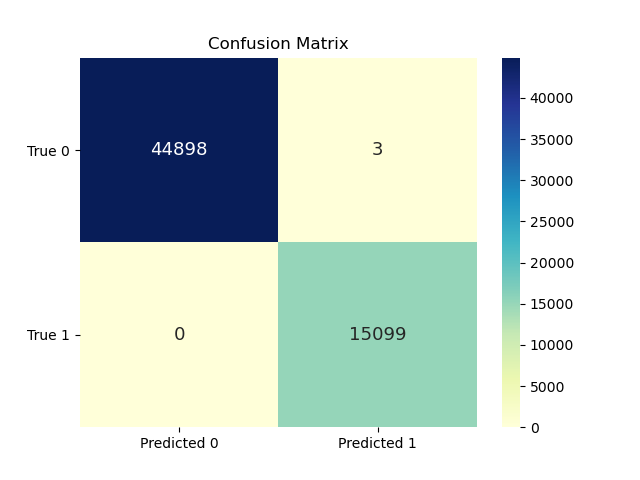

In [12]:
plt.title('Confusion Matrix')
sns.heatmap(confusion.astype(int),annot=True,cmap="YlGnBu",fmt='d',yticklabels=['True 0','True 1'],annot_kws={"fontsize":13});
plt.yticks(rotation=0);

In [27]:
classification= %sql SELECT y_test,pred FROM sensors_logreg_test_predict;
classification=classification.DataFrame()

print(classification_report(classification['y_test'],classification['pred']))

 * postgresql://gpadmin@192.168.133.128:32000/db
60000 rows affected.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44901
           1       1.00      1.00      1.00     15099

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



### ROC

In [28]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_auc;
SELECT
madlib.area_under_roc(
    'sensors_logreg_test_prob', 
    'sensors_logreg_test_auc', 
    'pred',  -- predictions, 
    'y_test'
);

SELECT * FROM sensors_logreg_test_auc;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
1 rows affected.


area_under_roc
0.999999997049974315675130175333038982720577080


## Linear Regression  ( Regression Model )

In [29]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_model;
DROP TABLE IF EXISTS sensors_linreg_model_summary;

SELECT madlib.linregr_train(
    'sensors_split_train',   -- source_table
    'sensors_linreg_model',  -- out_table
    'temperature_2',         -- labels
    'ARRAY[
        1,
        temperature,
        humidity,pm25,
        "month_January","month_February","month_March",
        "month_April","month_May","month_June",
        "month_July","month_August","month_September",
        "month_October","month_November","month_December"]',       -- feature
    NULL,  -- grouping_cols
    TRUE  -- heteroskedasticity_option
);

SELECT * FROM sensors_linreg_model LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.
1 rows affected.


[([13.9985584582425, 0.994181400876533, 0.000856707134511503, -0.00033709457999598, 1.13204353330593, 1.143045279436, 1.20741618336763, 1.16202824574812, 1.17478519254577, 1.20451259620586, 1.1540796746355, 1.21264244712017, 1.12588400956014, 1.19260399930142, 1.1272550017663, 1.16226229521819], 0.0841797515985558, [0.262033614301953, 0.00878336219057707, 0.000533931671840845, 0.000524372773897401, 0.0343432916794607, 0.0353916660412463, 0.0343970566427196, 0.034 ... (23 characters truncated) ... 0587762311, 0.0343411962352174, 0.0341717452171949, 0.034110586020659, 0.0344057893294665, 0.0342058904454044, 0.0344594330114698, 0.0342446964196322], [53.4227583569158, 113.189161428764, 1.60452578427839, -0.642852941220659, 32.9625809858804, 32.2970181201378, 35.1023111049586, 33.901443990366, 34.4915785455309, 35.0748584282167, 33.7729216725747, 35.5503258251189, 32.7236791104771, 34.8654569073395, 32.7125231976712, 33.9399211187597], [0.0, 0.0, 0.108600461534552, 0.52032058002156, 2.28438905905991e-237, 5.34559587560188e-228, 9.24831881540126e-269, 6.65307190434822e-251, 1.33020298 ... (22 characters truncated) ... 0264518e-268, 4.98892785144208e-249, 1.40571298099721e-275, 5.53911259076834e-234, 3.4385993206144e-265, 7.95978762399337e-234, 1.82107255757856e-251], inf, 10.0407118176474, 0.81717124394972, 140000, 0, [[0.0686616150241446, -0.00225434860136279, -1.35349890243418e-05, -1.58932886945193e-05, 0.00573653621781636, 0.00570927567087823, 0.0057241041614473 ... (5361 characters truncated) ... 00414478723091628, 0.000420496259626949, 0.000416697492792623, 0.000418655901766175, 0.000421463623287155, 0.000417425892415072, 0.00117269923287277]])]

In [30]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_test_predict;

CREATE TABLE sensors_linreg_test_predict
AS
SELECT 
    madlib.linregr_predict(
        coef, 
        ARRAY[
            1,
            temperature,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"
            ] 
    ) as prediction,
    test.temperature_2 as y_test
FROM sensors_split_test test, sensors_linreg_model model;

SELECT * FROM sensors_linreg_test_predict LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
60000 rows affected.
5 rows affected.


prediction,y_test
48.1327274765373,43.8821681298194
45.8301627751667,51.2642994942956
47.3269375235452,54.9473644193009
46.0825207552893,49.1253201300976
46.0340482765889,45.7392663315482


In [31]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_test_predict_mse;

SELECT madlib.mean_squared_error(
    'sensors_linreg_test_predict',      -- table_in
    'sensors_linreg_test_predict_mse',  -- table_out
    'prediction',  -- prediction
    'y_test'  -- y_test
);

SELECT * FROM sensors_linreg_test_predict_mse;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
1 rows affected.


mean_squared_error
9.04314927030701


In [32]:
pred = %sql SELECT * FROM sensors_linreg_test_predict LIMIT 200;
pred=pred.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
200 rows affected.


In [33]:
pred

,prediction,y_test
0,48.684182,50.258483
1,45.642878,49.642492
2,47.667135,47.024718
3,45.515449,46.042749
4,45.876071,45.219510
...,...,...
195,48.177231,49.459466
196,45.144934,46.927641
197,45.955277,39.083324
198,47.412924,44.795713


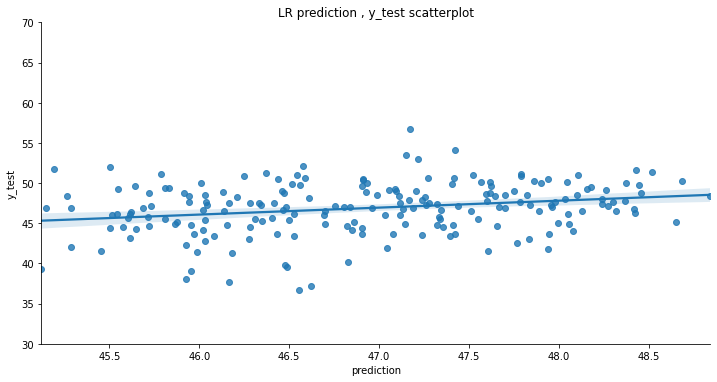

In [34]:
%matplotlib inline
sns.lmplot(x='prediction',y='y_test',data=pred,height=5,aspect=2)
plt.title("LR prediction , y_test scatterplot") 
plt.ylim(30,70);

## Multilayer Perceptron ( ANN )

In [44]:
%%sql
DROP TABLE IF EXISTS sensors_mlp_model;
DROP TABLE IF EXISTS sensors_mlp_model_standardization;

SELECT madlib.mlp_regression(
    'sensors_split_train',           -- source_table
    'sensors_mlp_model',             -- out_table
    'ARRAY[
        1,
        temperature,
        humidity,pm25,
        "month_January","month_February","month_March",
        "month_April","month_May","month_June",
        "month_July","month_August","month_September",
        "month_October","month_November","month_December"]',       -- feature
    'temperature_2',                 -- labels
    ARRAY[16],                       -- hidden_layer_sizes
    NULL,                            -- optimizer_params,
    NULL,                            -- activation,
    NULL,                            -- weights,
    NULL,                            -- warm_start,
    NULL,                            -- verbose,
    NULL                             -- grouping_col
);

SELECT * FROM sensors_mlp_model;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.
1 rows affected.


[([5.25670584140862, 0.0018554548633512, 0.555347086831187, -0.106807655206207, -0.0424818047371426, -0.00841389621115055, -0.0284668640402652, -0.01734 ... (5427 characters truncated) ... 4501, 0.371823607782054, 0.46760664465364, 0.433511080183296, 0.519758595384752, 2.5485000366175, 4.8150875020772, 2.88419774050372, 6.00816085472489], 5.56679360449262, 66)]

Mean and Standard Deviation for normalizing inputs

In [45]:
%%sql

SELECT * FROM sensors_mlp_model_standardization;

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


mean,std
"[1.0, 31.9998097553222, 50.0239741963145, 94.9075849979093, 0.0834571428571429, 0.0749357142857143, 0.0828642857142857, 0.0829571428571429, 0.0856642857142857, 0.08265, 0.0859071428571429, 0.0862714285714286, 0.0828857142857143, 0.0848928571428571, 0.08215, 0.0853642857142857]","[1.0, 0.914811902321368, 14.998929047432, 15.2207529108662, 0.276571958382019, 0.26328758613008, 0.27567697739809, 0.275817431113631, 0.27986767563859, 0.275352460493819, 0.280226882477869, 0.280764437177634, 0.275709398920424, 0.278722191346472, 0.274593112623023, 0.279423020595611]"


In [46]:
%%sql
SELECT 
    madlib.mlp_predict(
        'sensors_mlp_model',
        'sensors_split_test',
        'ARRAY[
            1,
            temperature,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"]',
        'sensors_mlp_test_predict',
        'response'
    );

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


mlp_predict
""


In [47]:
%%sql
DROP TABLE IF EXISTS sensors_mlp_test_predict;

SELECT 
    madlib.mlp_predict(
        'sensors_mlp_model',
        'sensors_split_test',
        'temperature_2',
        'sensors_mlp_test_predict',
        'response'
    );
    
SELECT * FROM sensors_mlp_test_predict LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


temperature_2,estimated_temperature_2
43.3934340393275,48.3204241580749
49.7321663797957,48.4934621436375
50.5813168067215,48.143796833076
41.163094159682,48.1279781773618
48.7028745951505,48.0704278050094


In [48]:
%%sql 
DROP TABLE IF EXISTS sensors_mlp_test_predict_mse;

SELECT madlib.mean_squared_error(
    'sensors_mlp_test_predict',      -- table_in
    'sensors_mlp_test_predict_mse',  -- table_out
    'estimated_temperature_2',  -- prediction
    'temperature_2'  -- y_test
);

SELECT * FROM sensors_mlp_test_predict_mse;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
1 rows affected.


mean_squared_error
11.183961249727


In [49]:
pred = %sql SELECT temperature_2 as y_test, estimated_temperature_2 as prediction FROM sensors_mlp_test_predict LIMIT 200;
pred=pred.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
200 rows affected.


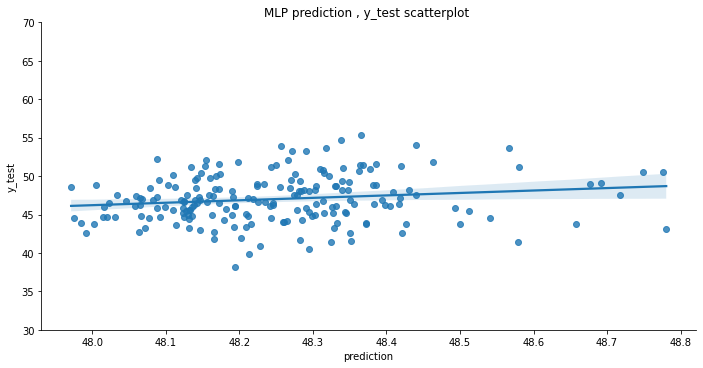

In [50]:
sns.lmplot(x='prediction',y='y_test',data=pred,height=5,aspect=2)
plt.title("MLP prediction , y_test scatterplot ") 
plt.ylim(30,70);